In [30]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

custom_cycler = (cycler(color=['c', 'm', 'y', 'k']) +
                 cycler(lw=[1, 2, 3, 4]))


name: Module_EGFR_1 | forward specie(s): EGFR | backward specie(s): uEGFR | type: MichaelisMentenGeneral
name: Module_EGFR_2 | forward specie(s): EGFR | backward specie(s): pEGFR | type: MichaelisMentenGeneral

vm_EGFR_to_uEGFR,0.2
km_EGFR_to_uEGFR,100
vm_uEGFR_to_EGFR,10
km_uEGFR_to_EGFR,100
km_EGFR_to_pEGFR,100
vm_pEGFR_to_EGFR,10
km_pEGFR_to_EGFR,100
kc_EGFR_to_pEGFR_EGF,1
EGF,('EGF', 8.33, 100)

EGFR,100
uEGFR,0
pEGFR,0
EGF,0



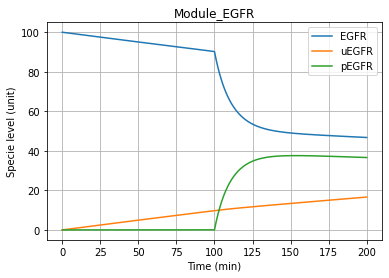

In [47]:
from src.OdeModel import OdeModel
import src.reactions as re

Module_EGFR = OdeModel('Module_EGFR')
Module_EGFR.addReaction(re.MichaelisMentenGeneral('EGFR', 'uEGFR', noBackward=True, Vmax_f=0.2))
Module_EGFR.addReaction(re.MichaelisMentenGeneral('EGFR', 'pEGFR'))
Module_EGFR.specieConc(['EGFR'], [100])
print(Module_EGFR)

Module_EGFR.addActivation('EGF', 8.33, 100)
Module_EGFR.addStimulator('Module_EGFR_2', 'EGF', kc=1)

print(Module_EGFR.getParams())
print(Module_EGFR.getStates())

Module_EGFR.simulate_beta(200)
Module_EGFR.plot(ignore_list=['EGF'])


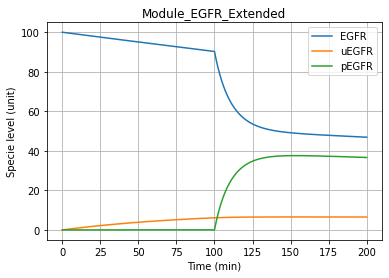

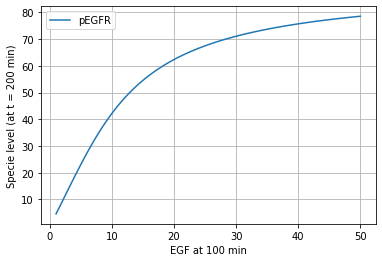

In [48]:
Module_EGFR_extended = OdeModel('Module_EGFR_Extended')
Module_EGFR_extended = Module_EGFR_extended.combine(Module_EGFR, 'Module_EGFR_Extended')
Module_EGFR_extended.addReaction(re.Synthesis('EGFR'))
Module_EGFR_extended.addReaction(re.Degradation('uEGFR'))
Module_EGFR_extended.addReaction(re.Degradation('EGFR', KDeg=0.0001))
Module_EGFR_extended.addReaction(re.Degradation('pEGFR', KDeg=0.0001))

Module_EGFR_extended.simulate_beta(200)
Module_EGFR_extended.plot(ignore_list=['EGF'])

# Analysing Module_EGFR using EGF as an input
# pEGFR is treated as an output

output_list = []
output_var = 'pEGFR'
input_var = 'EGF'

p_range = np.linspace(1, 50, 100)
for p in p_range:
    Module_EGFR.addActivation('EGF', p, 100)
    Module_EGFR.simulate_beta(200)
    o = Module_EGFR.extractStateValues(output_var)[-1]
    output_list.append(o)

plt.plot(p_range, output_list, label=output_var)
plt.legend()
plt.grid()
plt.xlabel('EGF at 100 min')
plt.ylabel('Specie level (at t = 200 min)')

plt.show()


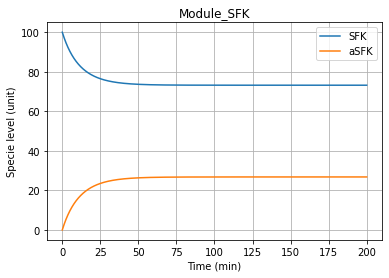

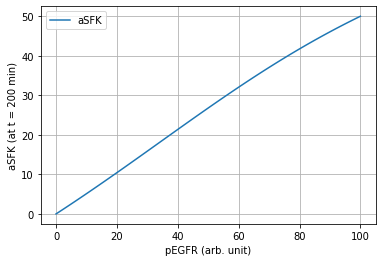

In [69]:
Module_SFK = OdeModel('Module_SFK')
Module_SFK.addReaction(re.MichaelisMentenGeneral('SFK', 'aSFK'))
Module_SFK.specieConc(['SFK'], [100])

Module_SFK.addStimulator('Module_SFK_1', "pEGFR")
Module_SFK.setState('pEGFR', 50)

Module_SFK.simulate_beta(200)
Module_SFK.plot(ignore_list=['pEGFR'])

# Input is pEGFR, output is pSFK

output_list = []
output_var = 'aSFK'
input_var = 'pEGFR'

p_range = np.linspace(0, 100, 100)
for p in p_range:
    Module_SFK.setState(input_var, p)
    Module_SFK.simulate_beta(200)
    o = Module_SFK.extractStateValues(output_var)[-1]
    output_list.append(o)

plt.plot(p_range, output_list, label=output_var)
plt.legend()
plt.grid()
plt.xlabel('pEGFR (arb. unit)')
plt.ylabel('aSFK (at t = 200 min)')

plt.show()


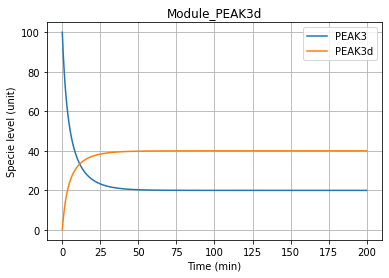

In [50]:
Module_PEAK3d = OdeModel('Module_PEAK3d')
Module_PEAK3d.addReaction(re.MassAction('PEAK3', 'PEAK3', 'PEAK3d'))
Module_PEAK3d.specieConc(['PEAK3'], [100])

Module_PEAK3d.simulate_beta(200)
Module_PEAK3d.plot()

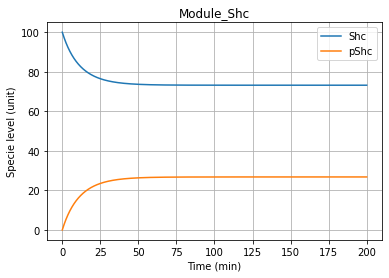

In [51]:
Module_Shc = OdeModel('Module_Shc')
Module_Shc.addReaction(re.MichaelisMentenGeneral('Shc', 'pShc'))
Module_Shc.specieConc(['Shc'], [100])

Module_Shc.addStimulator('Module_Shc_1', "pEGFR")
Module_Shc.setState('pEGFR', 50)

Module_Shc.simulate_beta(200)
Module_Shc.plot(ignore_list=['pEGFR'])


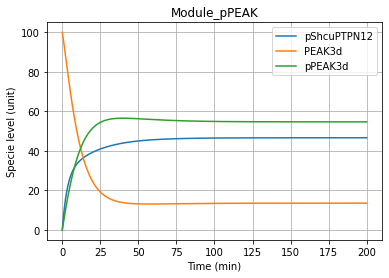

In [72]:
Module_pPEAK = OdeModel('Module_pPEAK')
Module_pPEAK.addReaction(re.MassAction('pShc', 'PTPN12'))
Module_pPEAK.addReaction(re.MichaelisMentenGeneral('PEAK3d', 'pPEAK3d', noBackward=True)) # Vmax also controls PEAK3d steady states, surprisingly
Module_pPEAK.addReaction(re.MassAction('pShcuPTPN12', 'PEAK3d', Kd=0.1)) # kd controls how much PEAK3d there are
Module_pPEAK.addReaction(re.MassAction('pShcuPTPN12', 'pPEAK3d', Kd=0.1)) # Ka controls how much pPEAK3d there are
Module_pPEAK.addReaction(re.MichaelisMentenGeneral('pShcuPTPN12upPEAK3d', 'pShcuPTPN12uPEAK3d', noBackward=True))

Module_pPEAK.specieConc(['pShc', 'PEAK3d'], [100, 100]) # INPUT: pShc controls the steady state of pPEAK3d and PEAK3d
Module_pPEAK.specieConc(['PTPN12'], [100])

Module_pPEAK.simulate_beta(200)
Module_pPEAK.plot(ignore_list=['pShcuPTPN12upPEAK3d', 'pShcuPTPN12uPEAK3d', 'PTPN12', 'pShc'])


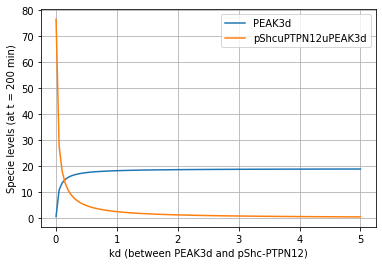

In [77]:
# Further analysis on Module_pPEAK
# input: (kd) dissociation constant for PEAK3d and pShc-PTPN12 complex
# output: PEAK3d, pShcuPTPN12uPEAK3d

output_list = []
output_var = 'PEAK3d'

o2l = []
o2 = 'pShcuPTPN12uPEAK3d'

p_range = np.linspace(0.001, 5, 100)
for p in p_range:
    Module_pPEAK.setParam('Module_pPEAK_3', 'kd', p)
    Module_pPEAK.simulate_beta(200)
    o = Module_pPEAK.extractStateValues(output_var)[-1]
    output_list.append(o)
    o2_ = Module_pPEAK.extractStateValues(o2)[-1]
    o2l.append(o2_)

plt.plot(p_range, output_list, label=output_var)
plt.plot(p_range, o2l, label=o2)
# plt.xscale('log')
plt.legend()
plt.grid()
plt.xlabel('kd (between PEAK3d and pShc-PTPN12)')
plt.ylabel('Specie levels (at t = 200 min)')

plt.show()


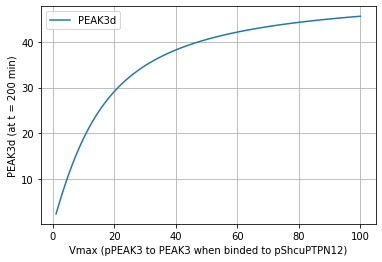

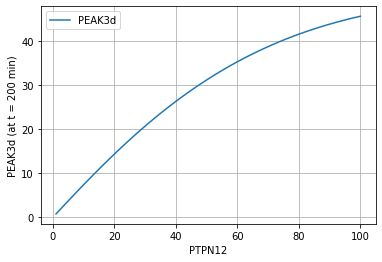

In [79]:
# Analysing Module_pPEAK a bit further... 

peak3d_list = []
other_list = []

p_range = np.linspace(1,100,100)
for p in p_range:
    Module_pPEAK.setParam('Module_pPEAK_5', 'vmaxf', p)
    Module_pPEAK.simulate_beta(200)
    peak3d = Module_pPEAK.extractStateValues('PEAK3d')[-1]
    other = Module_pPEAK.extractStateValues('pShcuPTPN12uPEAK3d')[-1]
    peak3d_list.append(peak3d)
    other_list.append(other)

plt.plot(p_range, peak3d_list, label='PEAK3d')
plt.legend()
plt.grid()
plt.xlabel('Vmax (pPEAK3 to PEAK3 when bound to pShcuPTPN12)')
plt.ylabel('PEAK3d (at t = 200 min)')

# plt.plot(kd_range, other_list)
plt.show()

peak3d_list = []

p_range = np.linspace(1, 100, 100)
for p in p_range:
    Module_pPEAK.setState('PTPN12', p)
    Module_pPEAK.simulate_beta(200)
    peak3d = Module_pPEAK.extractStateValues('PEAK3d')[-1]
    peak3d_list.append(peak3d)

plt.plot(p_range, peak3d_list, label='PEAK3d')
plt.legend()
plt.grid()
plt.xlabel('PTPN12')
plt.ylabel('PEAK3d (at t = 200 min)')
plt.show()


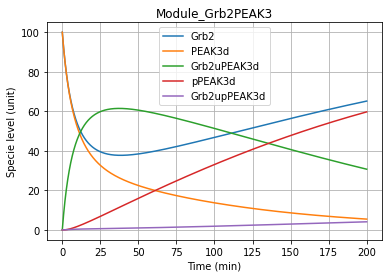

In [103]:
Module_Grb2PEAK3 = OdeModel('Module_Grb2PEAK3')
Module_Grb2PEAK3.addReaction(re.MassAction('Grb2', 'PEAK3d'))
Module_Grb2PEAK3.addReaction(re.MassAction('Grb2', 'pPEAK3d', Kd=1))
Module_Grb2PEAK3.addReaction(re.MichaelisMentenGeneral('Grb2uPEAK3d', 'Grb2upPEAK3d', noBackward=True))
Module_Grb2PEAK3.addStimulator('Module_Grb2PEAK3_3', 'aSFK')

Module_Grb2PEAK3.setState('aSFK', 100)
Module_Grb2PEAK3.specieConc(['Grb2', 'PEAK3d'], [100, 100])
Module_Grb2PEAK3.simulate_beta(200)
Module_Grb2PEAK3.plot(ignore_list=['aSFK'])


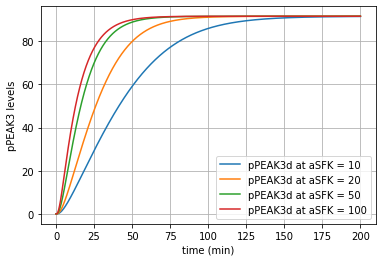

In [126]:
# In Module_Grb2PEAK3, due to its special structure involved with Grb2,
# aSFK concentrations only determines how fast PEAK3d is converted to pPEAK3d, 
# but not the steady state of pPEAK3d. I demonstrate this by plotting pPEAK3d 
# conc. against different aSFK concentrations
# I hypothesise this is due to Grb2 forming an internal 'loop' with PEAK3d and pPEAK3d 
# the loop is only caused by the one-way michaelian phosphorylation 

p_range = [10, 20, 50, 100]
output_var = 'pPEAK3d'

for p in p_range:
    Module_Grb2PEAK3.setState('aSFK', p)
    Module_Grb2PEAK3.setParam('Module_Grb2PEAK3_3', 'kcf_aSFK', 0.5)
    Module_Grb2PEAK3.simulate_beta(200)
    o = Module_Grb2PEAK3.extractStateValues(output_var)
    plt.plot(Module_Grb2PEAK3.t, o, label='{o} at aSFK = {n}'.format(o=output_var, n=str(p)))

plt.legend()
plt.grid()
plt.xlabel('time (min)')
plt.ylabel('pPEAK3 levels')

plt.show()


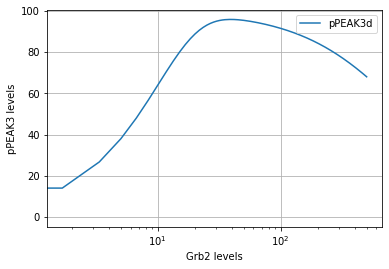

In [150]:
# I now show that, Grb2 conc. controls pPEAK3d concentration

Module_Grb2PEAK3.setParam('Module_Grb2PEAK3_3', 'kcf_aSFK', 0.1) # reset parameter
Module_Grb2PEAK3.setState('aSFK', 100)

output_list = []
output_var = 'pPEAK3d'
p_range = np.linspace(0, 500, 300)

for p in p_range:
    Module_Grb2PEAK3.setState('Grb2', p)
    Module_Grb2PEAK3.simulate_beta(200)
    o = Module_Grb2PEAK3.extractStateValues(output_var)[-1]
    output_list.append(o)

plt.plot(p_range, output_list, label=output_var)
plt.legend()
plt.grid()
plt.xlabel('Grb2 levels')
plt.xscale('log')
plt.ylabel('pPEAK3 levels')
plt.show()

# the tailend is not necessarily accurate due to poor sampling

The next part of code are for testing only

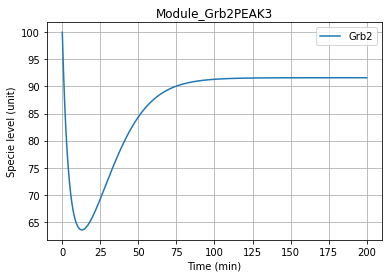

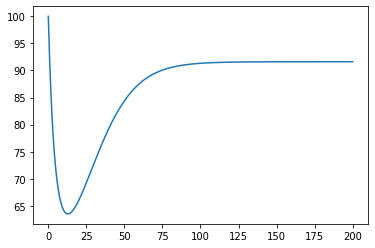

In [55]:
Module_Grb2PEAK3.plotOnly(only_print=['Grb2'])

a = Module_Grb2PEAK3.extractStateValues('Grb2')

# print(a[-1])

plt.plot(Module_Grb2PEAK3.t, a)
plt.show()


In [ ]:
# We combine Module_pPEAK3 with Module_Grb2PEAK3

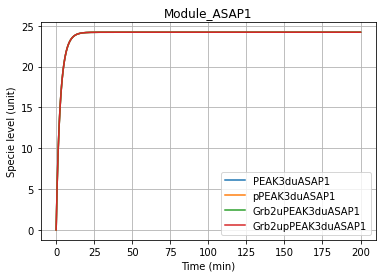

In [154]:
Module_ASAP1 = OdeModel('Module_ASAP1')
target = 'ASAP1'

peak3_vars = ['PEAK3d', 'pPEAK3d', 'Grb2uPEAK3d', 'Grb2upPEAK3d']
for p in peak3_vars:
    Module_ASAP1.addReaction(re.MassAction(p, target))

Module_ASAP1.specieConc(peak3_vars, [100] * 4)
Module_ASAP1.setState(target, 100)

ignore = peak3_vars.copy()
ignore.append(target)
Module_ASAP1.simulate_beta(200)
Module_ASAP1.plot(ignore_list=ignore)